# Topic modeling of enron emails

This notebook load a "cleaned" version of the [Kaggle Enron Email Dataset](https://www.kaggle.com/wcukierski/enron-email-dataset) generated in the notebook `00_gather_enron_email*` and 

In [94]:
# Import libraries
import warnings; warnings.simplefilter('ignore')
import os, sys, email
import numpy as np 
import pandas as pd


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')

import wordcloud

# Network analysis
import networkx as nx


import gensim
from gensim import corpora

#### Load the "clean" emails generated in step 00

In [95]:
## Read the data into a DataFrame
email_df = pd.read_csv('../../data/processed/clean_email.csv.zip',compression='zip')
print(email_df.shape)
email_df.head()


(354600, 6)


,Message-ID,From,To,Date,content,clean_content
0,<18782981.1075855378110.JavaMail.evans@thyme>,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),2001-05-14 16:39:00-07:00,Here is our forecast\n\n,forecast
1,<15464986.1075855378456.JavaMail.evans@thyme>,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),2001-05-04 13:51:00-07:00,Traveling to have a business meeting takes the...,traveling business meeting take fun trip espec...
2,<24216240.1075855687451.JavaMail.evans@thyme>,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),2000-10-18 03:00:00-07:00,test successful. way to go!!!,test successful way go
3,<13505866.1075863688222.JavaMail.evans@thyme>,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),2000-10-23 06:13:00-07:00,"Randy,\n\n Can you send me a schedule of the s...",randy send schedule salary level everyone sche...
4,<30922949.1075863688243.JavaMail.evans@thyme>,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),2000-08-31 05:07:00-07:00,Let's shoot for Tuesday at 11:45.,let's shoot tuesday 11:45


In [96]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select the one containing the key words we are interesting in
key_emails = email_df[email_df.clean_content.str.contains('|'.join(searchfor), na=False)]

key_emails.shape

(1988, 6)

#### Subsample the number of emails to speed up the analysis
The purpose of this subsampling stage is to be able to run the analysis faster. In a real case, there would be no particular reasons for subsampling.

In [97]:
# Only select the emails which are not in filtered_emails
email_df2=email_df[~email_df.index.isin(key_emails.index)]
print(f"Number of original emails without keywords: {email_df2.shape[0]}  ; number of emails with keywords:  {key_emails.shape[0]}")

# Subsample the dataframe to speed up the analysis, making sure the ratio of emails mentioning and not mentioning enron stock is kept constant
kemails_len = key_emails.shape[0] # "key" emails
nkemails_len = email_df2.shape[0] # "non key" emails
kemails = key_emails.sample(round(kemails_len/20),random_state=42)
nkemails = email_df2.sample(round(nkemails_len/20),random_state=42)

print(f"Number of subsampled emails: {nkemails.shape[0]}  ; number of subsampled emails with keywords:  {kemails.shape[0]}")


Number of original emails without keywords: 352612  ; number of emails with keywords:  1988
Number of subsampled emails: 17631  ; number of subsampled emails with keywords:  99


In [98]:
df = pd.concat([kemails,nkemails]).sort_index(ascending=True)
df=df.reset_index()

In [99]:
# NLP
import nltk
nltk.download(['stopwords','wordnet'])
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

def clean(text):
    if(type(text) != str): 
       text=str(text) 
    # Define stopwords and punctuation to exclude
    stop = set(stopwords.words('english'))
    stop.update(("to", "cc", "subject", "http", "from", "sent", "ect", "u", "fwd", "www", "com", 'html','pm'))
    exclude = string.punctuation
    
    # Import the lemmatizer from nltk
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    # Clean the text   
    text = text.rstrip()  # remove whitespace
    text = text.lower() # replace with lowercase
    punc_free = " ".join(word.strip(exclude) for word in text.split())
    stop_free = " ".join([i for i in punc_free.split() if((i not in stop) and (not i.isdigit()))])
     
    normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
#     # stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/locupe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/locupe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [100]:
# Get email content 
text_clean=[]
for text in df['content']:
    text_clean.append(clean(text).split())

## Topic modeling on fraud


#### Latent Dirichlet Allocation (LDA)

* With LDA you get:
    * "topics per text item" model (i.e. probabilities)
    * "words per topic" model
* Creating your own topic model:
    * Clean your data
    * Create a bag of words with dictionary and corpus
        * Dictionary contain words and word frequency from the entire text
        * Corpus: word count for each line of text
    * Feed dictionary and corpus into the LDA model
* LDA:
    * ![lda](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/lda.JPG)
    1. [LDA2vec: Word Embeddings in Topic Models](https://www.datacamp.com/community/tutorials/lda2vec-topic-model)
    1. see how each word in the dataset is associated with each topic
    1. see how each text item in the data associates with topics (in the form of probabilities)


### Create dictionary and corpus

In order to run an LDA topic model, we need to define a **dictionary and corpus**. The main stages are:
* use the `Dictionary` function in `corpora` to create a `dict` from the text data
    * contains word counts
* filter out words that appear in less than 5 emails and keep only the 50000 most frequent words
    * this is a way of cleaning the outlier noise
* create the corpus, which for each email, counts the number of words and the count for each word (`doc2bow`)
* `doc2bow`
    * Document to Bag of Words
    * converts text data into bag-of-words format
    * each row is now a list of words with the associated word count


In [101]:
# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Filter out (non)frequent words 
dictionary.filter_extremes(no_below=5, keep_n=50000)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [102]:
# Print corpus and dictionary
print(corpus[0][:10])
print(dictionary)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
Dictionary(24141 unique tokens: ['address', 'company', 'dns', 'gate', 'ip']...)


### LDA model

*The topic model is heavy to calculate and can take a while to run...*

In [103]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.009*"energy" + 0.008*"enron" + 0.007*"gas" + 0.007*"market" + 0.007*"company"')
(1, '0.016*"please" + 0.011*"message" + 0.011*"enron" + 0.009*"forwarded" + 0.008*"e-mail"')
(2, '0.019*"x" + 0.015*"enron" + 0.011*"e" + 0.009*"pst" + 0.009*"mid"')
(3, '0.010*"image" + 0.007*"new" + 0.006*"click" + 0.006*"please" + 0.005*"error"')
(4, '0.012*"know" + 0.011*"would" + 0.011*"deal" + 0.010*"get" + 0.009*"thanks"')


## Flagging fraud based on topic


Things that can be done:
1. Are there any suspicious topics? (no labels)
    1. if you don't have labels, first check for the frequency of suspicious words within topics and check whether topics seem to describe the fraudulent behavior
    1. for the Enron email data, a suspicious topic would be one where employees are discussing stock bonuses, selling stock, stock price, and perhaps mentions of accounting or weak financials
    1. Defining suspicious topics does require some pre-knowledge about the fraudulent behavior
    1. If the fraudulent topic is noticeable, flag all instances that have a high probability for this topic
1. Are the topics in fraud and non-fraud cases similar? (with labels)
    1. If there a previous cases of fraud, ran a topic model on the fraud text only, and on the non-fraud text
    1. Check whether the results are similar
        1. Whether the frequency of the topics are the same in fraud vs non-fraud
1. Are fraud cases associated more with certain topics? (with labels)
    1. Check whether fraud cases have a higher probability score for certain topics
        1. If so, run a topic model on new data and create a flag directly on the instances that score high on those topics

### Visualize LDA model results

In [104]:
import pyLDAvis.gensim
import warnings; warnings.simplefilter('ignore')

In [105]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

In [106]:
# Interactive display of the model
pyLDAvis.display(lda_display) 

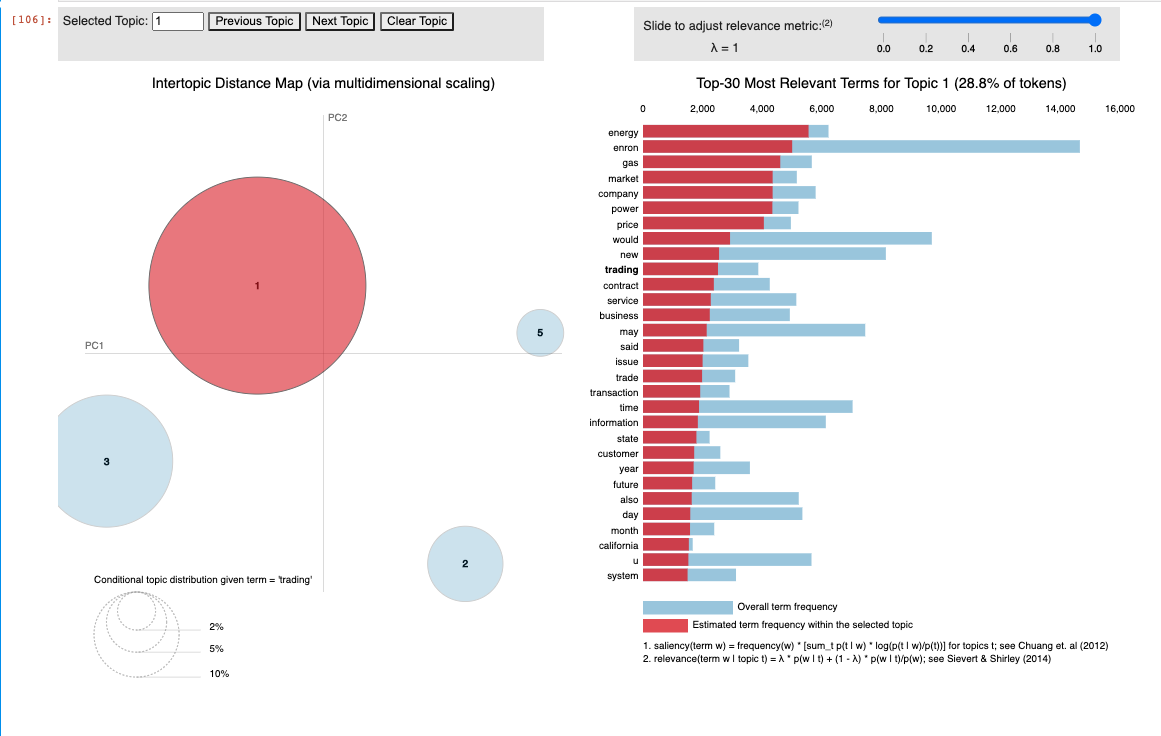

In [121]:
from IPython.display import Image, display
display(Image(filename='img/lda.png', embed=True))

From the visual inspection of the model results, it is not clear which topic is refering to fraudulent emails. More analysis is needed. 

### Get dominant topic for each email

##### Define function to get topic details from lda model results

In [107]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num+1, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [108]:
# Run get_topic_details function and check the results
topic_details_df = get_topic_details(ldamodel, corpus)

In [109]:
topic_details_df.tail()

,Dominant_Topic,% Score
17725,1.0,0.527888
17726,2.0,0.706835
17727,5.0,0.608964
17728,5.0,0.722523
17729,5.0,0.683460


In [110]:
topic_details_df.describe()

,Dominant_Topic,% Score
count,17730.000000,17730.000000
mean,3.154822,0.678588
std,1.568559,0.188493
min,1.000000,0.200000
25%,2.000000,0.525706
50%,3.000000,0.667508
75%,5.000000,0.839277
max,5.000000,0.999564


### Merged topic details with original text data

Concatenate column-wise the results from the previously defined function `get_topic_details()` to the original text data contained under `contents` and inspect the results.

In [111]:
# Add original text to topic details in a dataframe
contents = pd.DataFrame({'original_text': text_clean})
topic_details = pd.concat([topic_details_df, contents], axis=1)

In [112]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).head()

,Dominant_Topic,% Score,original_text
11332,1.0,0.999564,"[start, date, 4/19/01, hourahead, hour, ancill..."
4807,4.0,0.999447,"[southwest, airline, e-mail, update, february,..."
8233,4.0,0.999391,"[onepass, member, co.o.l, travel, special, dom..."
13892,4.0,0.999388,"[dear, susan, scott, today's, american, airlin..."
8211,4.0,0.999341,"[onepass, member, co.o.l, travel, special, dom..."


In [113]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).tail()

,Dominant_Topic,% Score,original_text
13190,4.0,0.999338,"[onepass, member, co.o.l, travel, special, dom..."
13949,4.0,0.999338,"[dear, susan, scott, today's, american, airlin..."
14554,1.0,0.999315,"[revised, notice, 00-408, december, comex, mem..."
6131,1.0,0.999312,"[notice, 01-77, march, comex, division, member..."
14258,1.0,0.999304,"[notice, 00-372, november, comex, members/memb..."


### List the topics associated with the emails mentioning the sell of the stock

In [114]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select the one containing the key words we are interesting in
df_keymsg = df[df.clean_content.str.contains('|'.join(searchfor), na=False)]


In [115]:
# Get the topics of the emails mentioning the sell
key_topics=topic_details[topic_details.index.isin(df_keymsg.index)]
key_topics['Dominant_Topic']


740      1.0
1294     1.0
1439     1.0
1496     5.0
1504     1.0
        ... 
16838    1.0
16903    1.0
17173    1.0
17267    1.0
17441    1.0
Name: Dominant_Topic, Length: 99, dtype: float64

<AxesSubplot:ylabel='Frequency'>

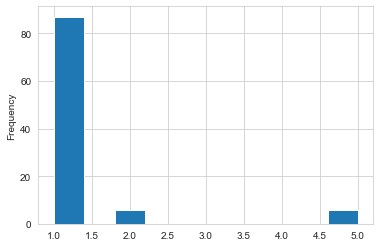

In [116]:
key_topics.Dominant_Topic.plot.hist()

**We can see that 80% of the emails mentioning the enron stock or the stock bonus are labelled with topic 1.**

### Flag all content (= emails) that has a dominent topic corresponding to topic 1

Create a flag with the `np.where()` function to flag all content that has topic 1 as a dominant topic with a 1, and 0 otherwise

In [117]:
# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 1.0), 1, 0)

In [118]:
# Extract all the emails with dopminant topic 1
topic_details_1 = topic_details[topic_details.flag == 1]

print(f"Number of emails with dominant topic 1: {topic_details_1.shape[0]} ")

Number of emails with dominant topic 1: 2942 


In [119]:
print("First 10 emails:")
topic_details_1.sort_values(by=['% Score'], ascending=False).head(10)

First 10 emails:


,Dominant_Topic,% Score,original_text,flag
11332,1.0,0.999564,"[start, date, 4/19/01, hourahead, hour, ancill...",1
14554,1.0,0.999315,"[revised, notice, 00-408, december, comex, mem...",1
6131,1.0,0.999312,"[notice, 01-77, march, comex, division, member...",1
14258,1.0,0.999304,"[notice, 00-372, november, comex, members/memb...",1
5767,1.0,0.999304,"[notice, 01-136, april, comex, division, membe...",1
16395,1.0,0.999286,"[fyi, forwarded, mark, taylor/hou/ect, 12/11/2...",1
7001,1.0,0.999188,"[attached, summary, recent, ferc, activity, pd...",1
5955,1.0,0.999030,"[notice, 00-370, november, nymex, comex, divis...",1
17632,1.0,0.998875,"[california=01,s, power, crisis, generated, he...",1
14555,1.0,0.998658,"[new, york, mercantile, exchange, member, neal...",1


##### Example of content flagged as suspicious

In [120]:
df.loc[6584,'content']

'To:  Enron North America Corp.\n\nFrom:  Cliff Baxter and Kevin Hannon\n\n\nIn July, as part of the Enron North America (ENA) reorganization, the=20\nimplementation of several objectives were highlighted as critical to the=20\ncontinued growth of ENA including: 1) accelerate the development of our=20\npeople, 2) significantly expand our customer network and associated markets=\n,=20\nand 3) accelerate and enhance the information flow between groups, both=20\nwithin ENA and across Enron. Consistent with these objectives and with the=\n=20\ncorporate goal of fostering =01&One Enron=018, we would like to announce th=\ne=20\nfollowing organizational changes in the Coverage/Origination Groups and the=\n=20\nCommercial Transactions Group within ENA.\n\n1) Coverage/Origination:\n\nTo ensure a consistent strategy, the free flowing of resources and product=\n=20\ntechnology and the appropriate focus in the midstream and downstream=20\nbusinesses, the following coverage/origination groups will 